# Visual odometry using monocular vision

The purpose of this project is to determine the displacement of the camera based on the series of frames it captures.

## Theory

In order to determine the displacement of the camera, based on the series of frames it captures, we have to somehow determine its movement between consecutive frames. The movement of an arbitrary object can be described using two matrices: *rotation matrix (3x3)* and *translation vector (3x1)*. Considering an example in which the rotation matrix is represented by *__R__*, the translation vetor by *__T__*, coordinates (in 3D) of the camera in the first frame by *__P__* and coordinates (also in 3D) of the camera in the second frame by *__P'__*, the calculation of the new position of the camera will be done as follows: *__P'__* = *__RP__* + *__T__*.

Both matrices can be found from the essential matrix, which in turn, can be calculated using the fundamental matrix. Fundametal matrix is a 3x3 matrix that relates the corresponding points in consecutive frames. Lets assume that *__x__* and *__x'__* are the coordinates of the corresponding points in two consecutive frames (in 2D since we are operating on RGB images without any additional information) and the fundamental matrix is represented by *__F__*, then we can construct the following equation: *__$x'^{T}$Fx__* = 0, where 
\begin{equation*}
{x'}^T = \begin{vmatrix}
\ u' & v' & 1 
\end{vmatrix}
\end{equation*}

\begin{equation*}
x = \begin{vmatrix}
\ u \\
\ v \\
\ 1 
\end{vmatrix}
\end{equation*}


The fundamental matrix has 7 degrees of freedom. There are 9 matrix elements, but only their ratio is significant, which leaves 8 degrees of freedom. In addition the elements satisfy the constraint *__det(F)__* = 0 which leaves only 7 degrees of freedom. The fundamental matrix is only affected by the direction of the translation and not the magnitude.

Having the fundamental matrix is the key to calculate the essential matrix (*__E__*). The essential matrix, similarly to the fundamental matrix, is a 3x3 matrix that relates the corresponding points in consecutive frames. The relation between the fundamental matrix and the essential matrix, is as follows: *__E__* = *__$K'^{T}$FK__*, where *__K'__* and *__K__* are  the intrinsic calibration matrices of the two images involved, which in case of the monocular vision, will be the same.

The essential matrix has 5 or 6 degrees of freedom, depending on whether or not it is seen as a projective element. The *rotation matrix* and the *translation vector* have 3 degrees of freedom each, in total 6. If the essential matrix is considered as a projective element, however, 1 degree of freedom related to scalar multiplication must be subtracted leaving 5 degrees of freedom in total. The reduction in freedom results in extra constraints on the singular values of *__E__*. In addition to having det(*__E__*) = 0 the two non-zero singular values have to be equal. Furthermore, since the scale is arbitrary we can assume that these singular values are both 1. Therefore *__E__* has the *SVD (Singular Value Decomposition)* as follows: *__E__* = *__Udiag([1 1 0])$V^{T}$__*. Since the essential matrix has only 5 degrees of freedom it is possible to find it using only 5 correspondences, what is also mentioned in the later section. Now having the SVD of *__E__* we create one more matrix, lets call it *__W__*, where 
\begin{equation*}
W = \begin{vmatrix}
\ 0 & -1 & 0 \\
\ 1 & 0 & 0 \\
\ 0 & 0 & 1
\end{vmatrix}
\end{equation*}

Using matrices obtained from the *SVD* and *__W__* we can calculate two possible rotation matrices (*__$R_{1}$__* and *__$R_{2}$__*) as follows: *__$R_{1}$__* = *__U$W^{T}$$V^{T}$__* and *__$R_{2}$__* = *__UW$V^{T}$__*. To see that *__$R_{1}$__* and *__$R_{2}$__* are the valid rotation matrices we can check the following constraints:
<br>1) *__$R^{T}$R__* = *__I__*, so *__R__* is orthogonal.
<br>2) det(*__R__*) = 1.

Now using the *__U__* matrix, obtained from *SVD* of the essential matrix, we can find the translation vector *__T__*, that is the last column of the *__U__* matrix, up to scale. Having this matrices we obtain 4 possible solutions [$R_{1}$, *__T__*], [$R_{1}$, *__-T__*], [$R_{2}$, *__T__*], [$R_{2}$, *__-T__*], from which we choose the pair for which points are in front of the camera (*cheirality check*).

## Practice

In [1]:
import cv2
import numpy as np
import os
import math
import re
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline
# width, height
plt.rcParams["figure.figsize"] = (12, 9)

In two consecutive frames, keypoints are marked as circles and their correspondances are shown by the line.

In [3]:
def draw_keypoints_correspondances(first_set, second_set, first_frame, second_frame, matches):
    print("Corresponding keypoints.")
    fig=plt.figure(figsize=(20, 20), dpi=180)
    fig.add_subplot(1, 1, 1)
    output_frame = cv2.drawMatches(first_frame, first_set, second_frame, second_set, matches, None)
    plt.imshow(output_frame)
    plt.show()

The keypoint in the current frame is the origin of the arrow. The tip of the arrow is the place of the corresponding keypoint in the next frame, shown on the current frame.

In [4]:
def draw_matches_displacement(first_set, second_set, frame):
    if len(first_set) > 0 and len(second_set) > 0:
        print("Keypoints displacement.")
    for p1, p2 in zip(first_set, second_set):
        cv2.arrowedLine(frame, (int(p1[0]), int(p1[1])), (int(p2[0]), int(p2[1])), (255, 0, 0), 2)
    plt.imshow(frame)
    plt.show()

The names of the frames need to be loaded and sorted assuming that the frames are numbered from 0 to N and that, except of the frame number, there are no more numbers in the name of the frame.

In [5]:
directory = "test_z_plus_rotation"
frame_names = [name for name in os.listdir("{}".format(directory)) if name.endswith(".bmp")]
try:
    frame_names = sorted(frame_names, key = lambda x: int(re.findall(r"\d+", x)[0]))
except IndexError:
    pass

The frames used later for displacement calculation are presented below.

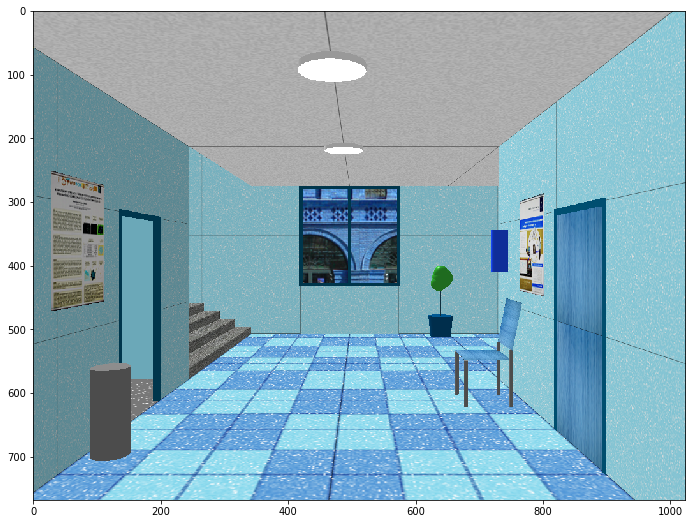

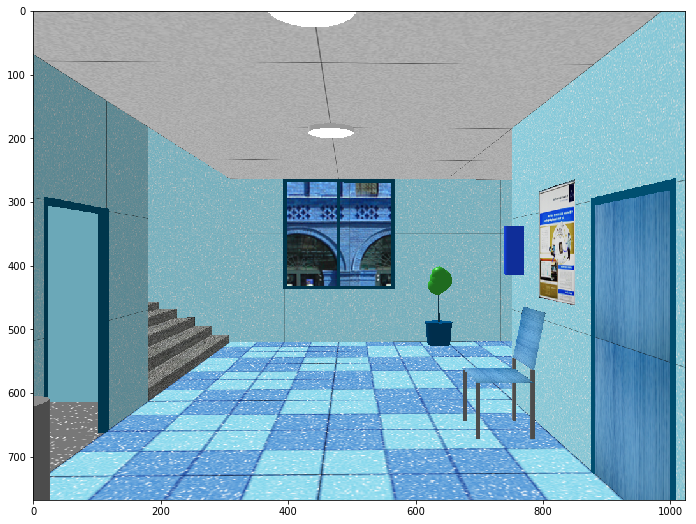

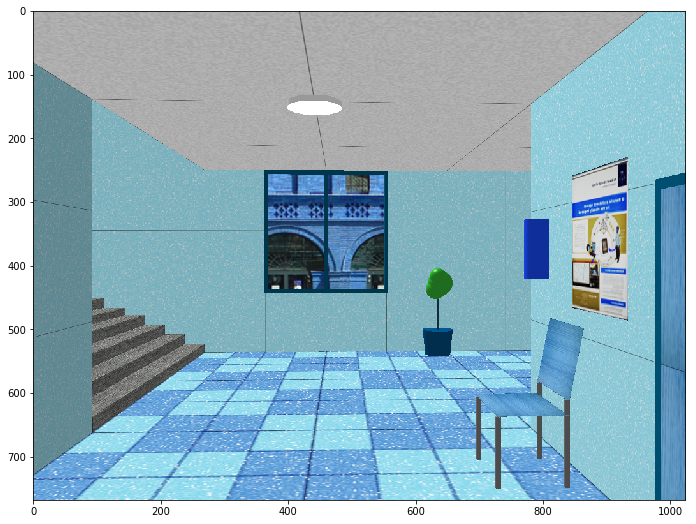

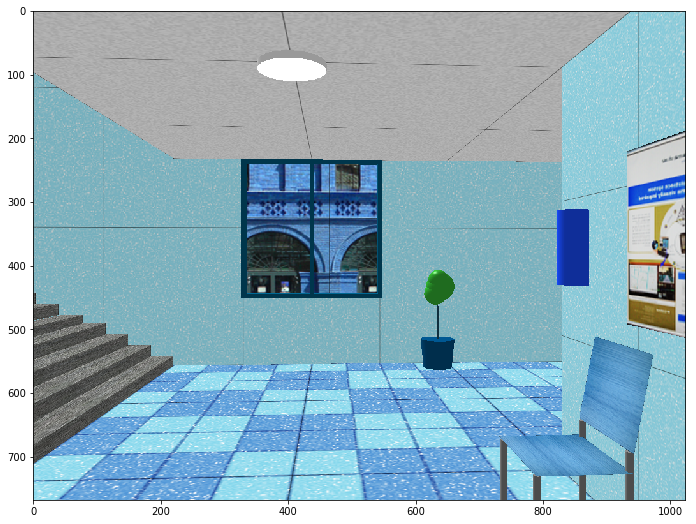

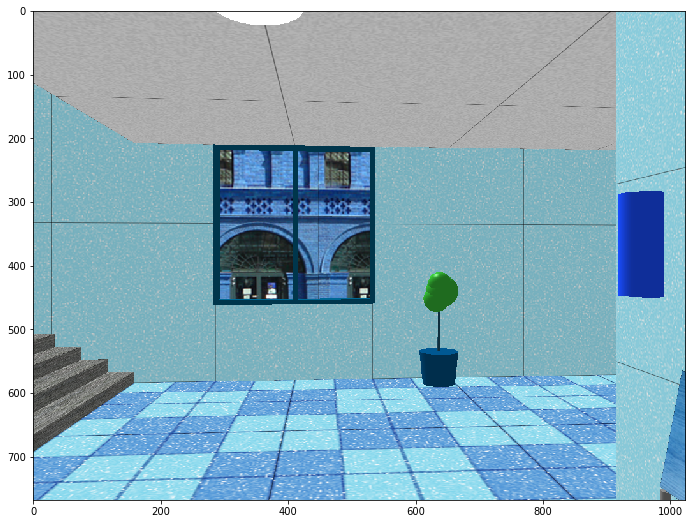

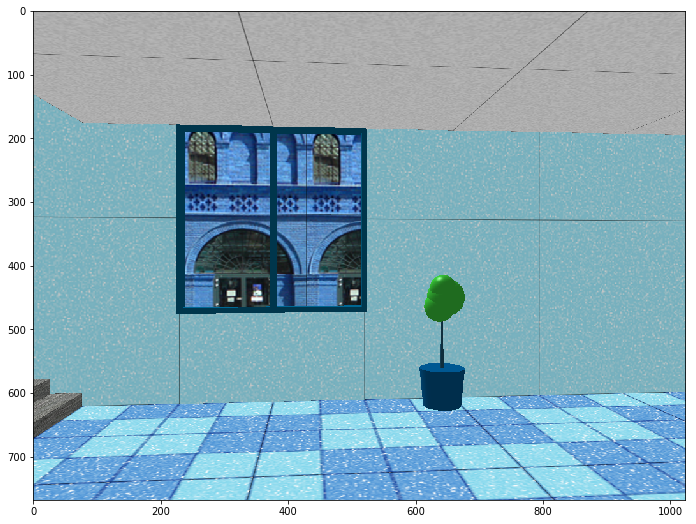

In [6]:
for frame_name in frame_names:
    frame = cv2.imread('{}/{}'.format(directory, frame_name), 1)
    draw_matches_displacement([], [], frame)

## Camera parameters

Since we use monocular camera, some additional information about the camera is required in order to obtain reliable results.
K is the instrinsic camera parameters matrix. It contains information, mainly, about the focal length and the principle point.
The principal point is assumed to be in the center of the image and the skew coefficient between the x and the y axis is 0 (position [0,1] in the matrix).

In [7]:
frame = cv2.imread('{}/{}'.format(directory, frame_names[0]), 1)

focal_length = 843.0
width_center = frame.shape[1] / 2
height_center = frame.shape[0] / 2

K = np.zeros((3, 3), dtype=float)
K[0,0] = focal_length
K[1,1] = focal_length
K[2,2] = 1
K[0,2] = width_center
K[1,2] = height_center
print(K)

[[843.   0. 512.]
 [  0. 843. 384.]
 [  0.   0.   1.]]


## Matches coordinates

Having matches we can create two sets of corresponding points coordinates. The corresponding points are under the same indices.

In [8]:
def extract_coordinates(matches, key_points1, key_points2):
    set1 = []
    set2 = []
    for match in matches:
        set1 += [key_points1[match.queryIdx].pt]
        set2 += [key_points2[match.trainIdx].pt]

    set1 = np.array(set1, dtype=np.float32)
    set2 = np.array(set2, dtype=np.float32)
    
    return set1, set2

## Euler angles

Having a 3x3 rotation matrix, obtained from the *recoverPose()* function, we can calculate 3 elementary Euler angles, sometimes referred to as yaw/pitch/roll. There are a few ways to accomplish it and all of them are valid. But the approach used here is based on the one presented in: http://nghiaho.com/?page_id=846. Calculated values are expressed in radians.

In [9]:
def calculate_euler_angles(rotation):
    x_angle = math.atan2(rotation[2,1] , rotation[2,2])
    y_angle = math.atan2(-rotation[2,0], math.sqrt(rotation[2,1] ** 2 + rotation[2,2] ** 2))
    z_angle = math.atan2(rotation[1,0], rotation[0,0])
    return x_angle, y_angle, z_angle

## Features detection and matching

The first stage of this algorythm is to find key points and corresponding descriptors for each frame. This was achieved using the ORB (Oriented FAST and Rotated BRIEF) algorythm. The default value of 500 key points was changed to 600. Having key points and descriptors we are able to match corresponding points between frames. Brute-Froce Matcher was used for this purpose, because more robust FLANN Based Matcher (Fast Library for Approximate Nearest Neighbors) does not provide repeatable results. 
The normType argument for the matcher, that specifies the distance measurement to be used, is set to NORM_HAMMING (uses Hamming distance as measurement), because in case of ORB we have to deal with binary string based descriptors.The knn match was used with k = 2 in order to be able to apply the Lowe's ratio test. Having matched descriptors we can find the coordinates of the corresponding points, what will be used for displacement calculation.

In [10]:
orb = cv2.ORB_create(nfeatures=600)

bf = cv2.BFMatcher(normType=cv2.NORM_HAMMING)

kp1, des1 = orb.detectAndCompute(frame, None)

## Lowe's ratio

As mentioned above, the Lowe's ratio test is applied in order to find only good matches. The match is considered a good match, if the difference in distance for the 2 of the matched descriptors, for the tested descriptor, is big enough (in this case distance1 < 0.7 * distance2), where distance means the distance between descriptors. The lower, the better it is.

In [11]:
def filter_matches(matches):
    good_matches = []
    for match in matches:
        if len(match) == 2:
            if match[0].distance < 0.7 * match[1].distance:
                good_matches.append(match[0])
        elif len(match) == 1:
            good_matches.append(match[0])
    return good_matches

We will assume that our camera movement starts from point (0, 0, 0) and does not have any rotation (also zeros).

In [12]:
camera_position = np.zeros((3,1), dtype=np.float)
angle_x, angle_y, angle_z = 0, 0, 0

The below conditions are introduced in order to avoid the following cases:
<br>1) When there is no movement the translation vector contains non zero elements. All elements of this matrix have almost the same absolute value (with some accuracy, thats why we do not use "==" check). If all of the values in this matrix are the same (considering the absolute value), but not almost zero, we should skip this frame, because there is no movement. Since in the real world (considering the fork lift) the movemement in the "y" direction (up and down) should not occure at all, so checking if all of the elements of the translation vector are the same is safe and will not degrade the results.
<br>2) When after applying the calculated movement we obtain big jump in the values with the sign change. This issue is directed in cases where the chosen rotation and translation matrices are not correct (in most cases the value is good but the sign is wrong), due to the mistakes in points matching, in categorization to inliers and outliers and in result of the *cheirality check*.
<br>3) When no more than 1 point passes the *cheirality check*. As pointed out before it can lead to the situation where we choose the wrong pair of matrices.

In [13]:
def conditions_fullfield(current_coordinates, new_coordinates, translation, mask):
    abs_x = abs(translation[0])
    abs_y = abs(translation[1])
    abs_z = abs(translation[2])
    threshold = 10 ** -5
    if  abs(abs_x - abs_y) <= threshold and \
        abs(abs_x - abs_z) <= threshold and \
        abs(abs_y - abs_z) <= threshold and \
        abs_x              >= threshold and \
        abs_y              >= threshold and \
        abs_z              >= threshold:
        return False
    elif   (current_coordinates[0][0] >= 1 and new_coordinates[0][0] <= -1) \
        or (current_coordinates[0][0] <= -1 and new_coordinates[0][0] >= 1) \
        or (current_coordinates[2][0] >= 1 and new_coordinates[2][0] <= -1) \
        or (current_coordinates[2][0] <= -1 and new_coordinates[2][0] >= 1):
        return False
    elif   len([x for x in mask if x == 1]) < 2:
        return False
    
    return True

## Displacement

Having two sets of corresponding points coordinates, we can find the rotation and translation of the camera. The first step is to find essential matrix, this is done by the function *findEssentialMatrix()*. It is a 3x3 matrix containing the information about the translation and rotation. It is calculated using *D. Nisters'* algorythm, that is described in the article *"An efficient solution to the five-point relative pose problem"*. We need at least 5 points correspondaces to proceed. However since we expect that some of the matches are outliers, we consider that the minimum number of key points correspondances should be 10. In the above algorythm the calssification to inliers and outliers is done by the *RANSAC (Random sampe consensus)* algorythm. The idea is to choose from the set of points a random subset and to fit a linear model to this subset. This proces is repeated several times. Finally the model with the smallest error is chosen, based on the assumption that the linear correlation is bigger for the inliers than for the random points. The effectiveness of this algorythm, depends on the ratio of inliers to outliers, due to the fact that the points are selected randomly from the whole set of points. We cannot be sure that the chosen set contains only inliers, so the bigger the ratio between inliers and outliers, the better the result of this algorythm.
The next step is to pass previously calculated essential matrix and mask, containing information which points are considered inliers, to the function *recoverPose()*. This function uses the *SVD (Singular Value Decomposition)* decomposition to find all 4 possible pairs of the translation and rotation matrix, that are [$R_{1}$, t], [$R_{1}$, -t], [$R_{2}$, t], [$R_{2}$, -t]. Having all 4 pairs, points correspondances and using the *cheirality check* (that basically means that the triangulated 3D points should have positive depth), the function chooses the right pair from 4 available. After this step we are able to determine the translation and rotation of the camera.

In [14]:
for frame_name in frame_names[1:]:
     
    next_frame = cv2.imread('{}/{}'.format(directory, frame_name), 1)

    kp2, des2 = orb.detectAndCompute(next_frame, None)

    matches = bf.knnMatch(des1, des2, k=2)
    
    filtered_matches = filter_matches(matches)
    
    first_set, second_set = extract_coordinates(filtered_matches, kp1, kp2)
    
    #draw_keypoints_correspondances(kp1, kp2, frame, next_frame, filtered_matches)  
    
    #draw_matches_displacement(first_set, second_set, frame)
    
    if first_set.shape[0] >= 10:

        essential_matrix, mask = cv2.findEssentialMat(first_set, second_set, focal_length, (width_center, height_center), cv2.RANSAC, 0.999, 1.0)
        
        _, rotation, translation, mask = cv2.recoverPose(essential_matrix, first_set, second_set, K, mask=mask)
        
        current_position = camera_position
        new_position = np.matmul(rotation, camera_position) + translation
        
        if not conditions_fullfield(current_position, new_position, translation, mask):
            pass
        else:
            x, y, z = calculate_euler_angles(rotation)
            angle_x += x
            angle_y += y
            angle_z += z
            print("Rotation: x: {}, y: {}, z: {}".format(x, y, z))

            camera_position = new_position
            kp1 = kp2
            des1 = des2
            frame = next_frame
    else:
        print("Not enough corresponding features found")

Rotation: x: -0.0011932393891043143, y: -0.01838612306206532, z: 0.0009030925278299495
Rotation: x: -0.001088625590095309, y: -0.017539363711301867, z: 0.0020343018732801527
Rotation: x: -0.0010106783500946552, y: -0.01840977665741288, z: 0.0023535575215016006
Rotation: x: 0.0014066612088499471, y: -0.019118356794104244, z: -0.0023448115309635067
Rotation: x: -0.001932539920048323, y: -0.0181629146769411, z: 0.0007145166720133444


In [15]:
print(camera_position)

[[ 0.25896021]
 [-0.06098942]
 [-4.98974869]]


In [16]:
print(angle_x, angle_y, angle_z)

-0.003818422040492654 -0.0916165349018254 0.0036606570636615403
